# Project 2: Predicting Diabetes Outcome for Women  

**Author : Mahamadou Ousmane Keita, Rosine Muna, Malathi Karuppasamy, Jean Daniel Houssou, Arthur Choisnet, Andrei Roumiantsev**

# I. Introduction: A Description of the Dataset and the Problem at Hand  

The project focuses on predicting diabetes outcomes using machine learning models based on the **TAIPEI_diabetes.csv dataset**, which contains data on **15,000 women aged 20–80** who visited Taipei Municipal Medical Center between 2018–2022. The dataset includes **8 features** such as pregnancies, plasma glucose levels, BMI, and family history, with the target variable indicating whether diabetes was diagnosed.  

The objective is to build and deploy a predictive model capable of classifying individuals as diabetic or non-diabetic. The end product will be a **web application** that allows users to input individual health metrics and receive a diabetes prediction in real-time, supporting better diagnostic decision-making.  

# II. Exploratory Data Analysis and Feature Engineering  

Let's first take a look at a few individuals from the dataset so that we can gain a more detailed insight into the structure of the data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

df= pd.read_csv("TAIPEI_diabetes.csv")

df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


As we can see, we mostly have numerical variables, which align with the project instructions.  

We can notice that the **Diabetic** variable, which is our target variable, is actually categorical, with **0** indicating that the individual has not been diagnosed with diabetes and **1** otherwise.  

For now, let's focus on the **PatientID** variable, which, as its name suggests, represents the ID of our patient.  

Let's check if some patients have multiple diagnoses recorded in the dataset.

In [2]:
### Check if all values in the column are unique

# Print the result
if df["PatientID"].is_unique:
    print(f"All values in the column PatientID are unique.")
else:
    print(f"The column PatientID contains duplicate values.")

    # Display duplicate values (if any)
    df_duplicated = df[df["PatientID"].duplicated()]
    print("\nWe have",len(df_duplicated),"duplicated values in the column PatientID \n ")
    print("The total number of individuals in the dataset with a duplicated PatientID is::",
    len(df[df["PatientID"].duplicated(keep=False)]["PatientID"]))

The column PatientID contains duplicate values.

We have 105 duplicated values in the column PatientID 
 
The total number of individuals in the dataset with a duplicated PatientID is:: 210


As we can see, we have **105 patients** who have more than one entry in the dataset, resulting in a total of **210 duplicated PatientIDs**. This suggests that some patients returned for a second registration of their information.  

Before deciding whether to delete or retain the duplicated values, we need to assess the value they add to the dataset.  

Let's check this with an example.

In [3]:
#One example
print(df[ df["PatientID"] == df_duplicated["PatientID"].iloc[0] ])

#Cleaning my workroom
del df_duplicated

      PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
760     1429759            8             92                      67   
1685    1429759            1            113                      65   

      TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  \
760                 48           171  36.300158          0.153597   39   
1685                20            73  45.593722          0.768987   46   

      Diabetic  
760          1  
1685         1  


In this example, we can see that for the same **PatientID**, the recorded information can be completely different, except for the target variable, which is the **Diabetic** column.  

This is interesting because it means we can gather more information about our **Diabetic** variable, regardless of whether the diagnosis is positive or negative.  

Let's now confirm that all duplicated **PatientID** entries provide new information.

In [4]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

print("We have in reality",
                            len(df),
        "individual that are not duplicated.")

We have in reality 15000 individual that are not duplicated.


Now that we know all the information in the dataset is unique and adds value (with **15,000** being the total number of individuals from the complete database), we can move on to another topic.  

Let's check if there are any missing values in the dataset.

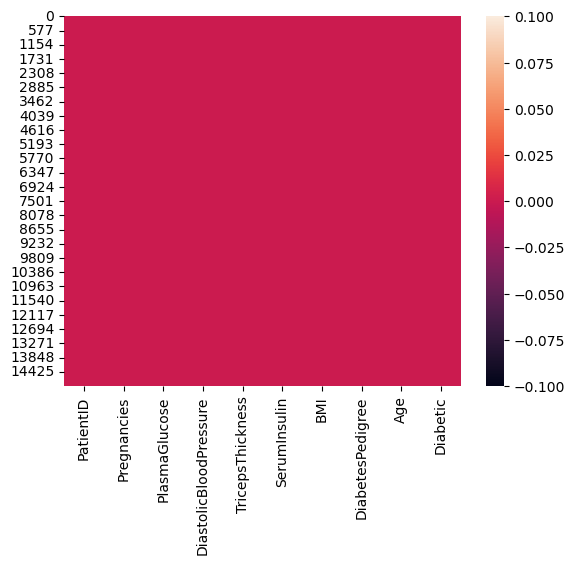

In [5]:
import seaborn as sns

sns.heatmap(df.isna())

# Let's drop the PatientID columns
df.drop(columns="PatientID", inplace=True)

There are no missing values, so we can proceed.  

We will drop the **PatientID** column for the rest of the analysis because it is not useful and takes up unnecessary space.  

Now, it’s time to check if there are any outliers we need to address and whether there is any imbalance in the **Diabetic** variable that we should consider.

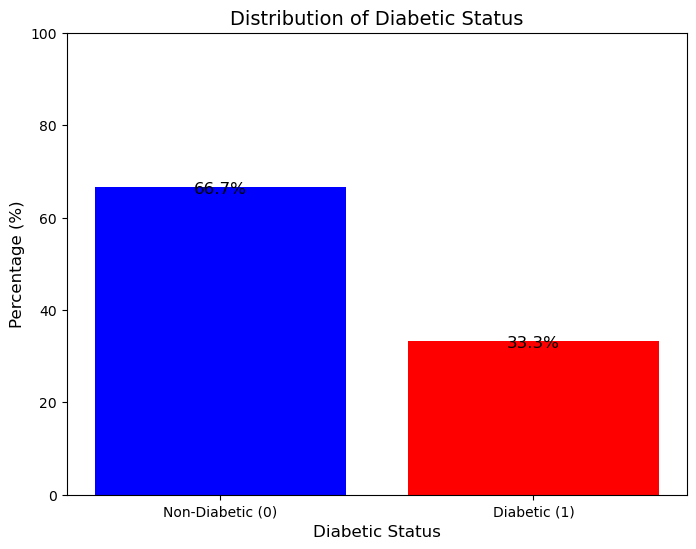

In [6]:
from util import plot_diabetic_distribution

plot_diabetic_distribution(df)

We have an imbalance in the target variable, which is the **Diabetic** variable, so we need to take that into consideration when dealing with outliers.

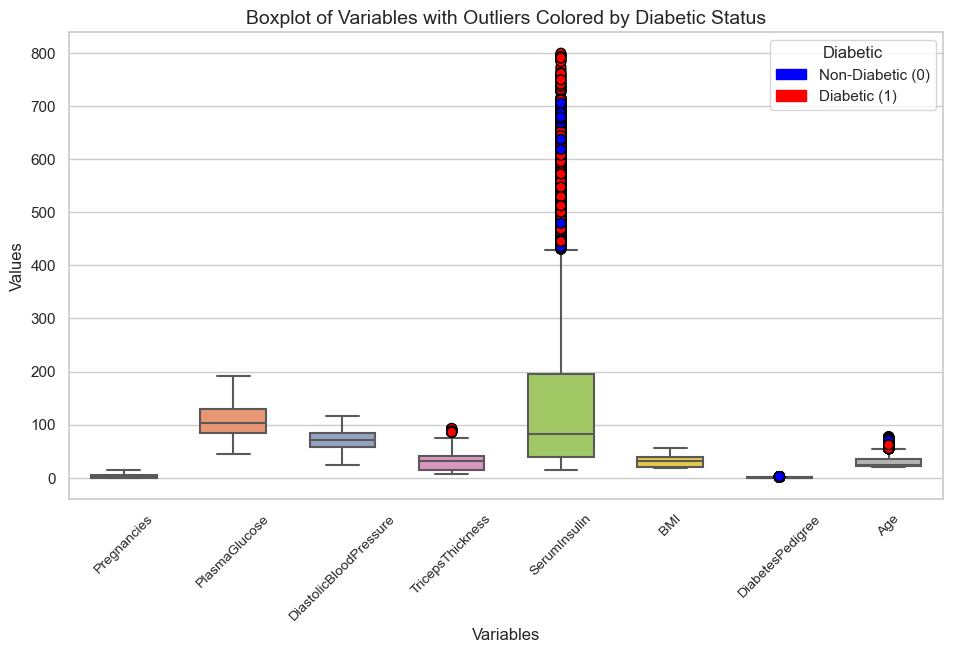

In [7]:
from util import plot_boxplot_with_outliers

plot_boxplot_with_outliers(df, id_var='Diabetic')

In terms of outliers, we have 4 variables to consider. The **Serum Insulin** appears to be the most challenging case to study. We can also note that our outliers are primarily concerned with higher values, not lower values (to confirm with the **DiabetesPedigree** variable).

Let's take a deeper look at those 4 variables.

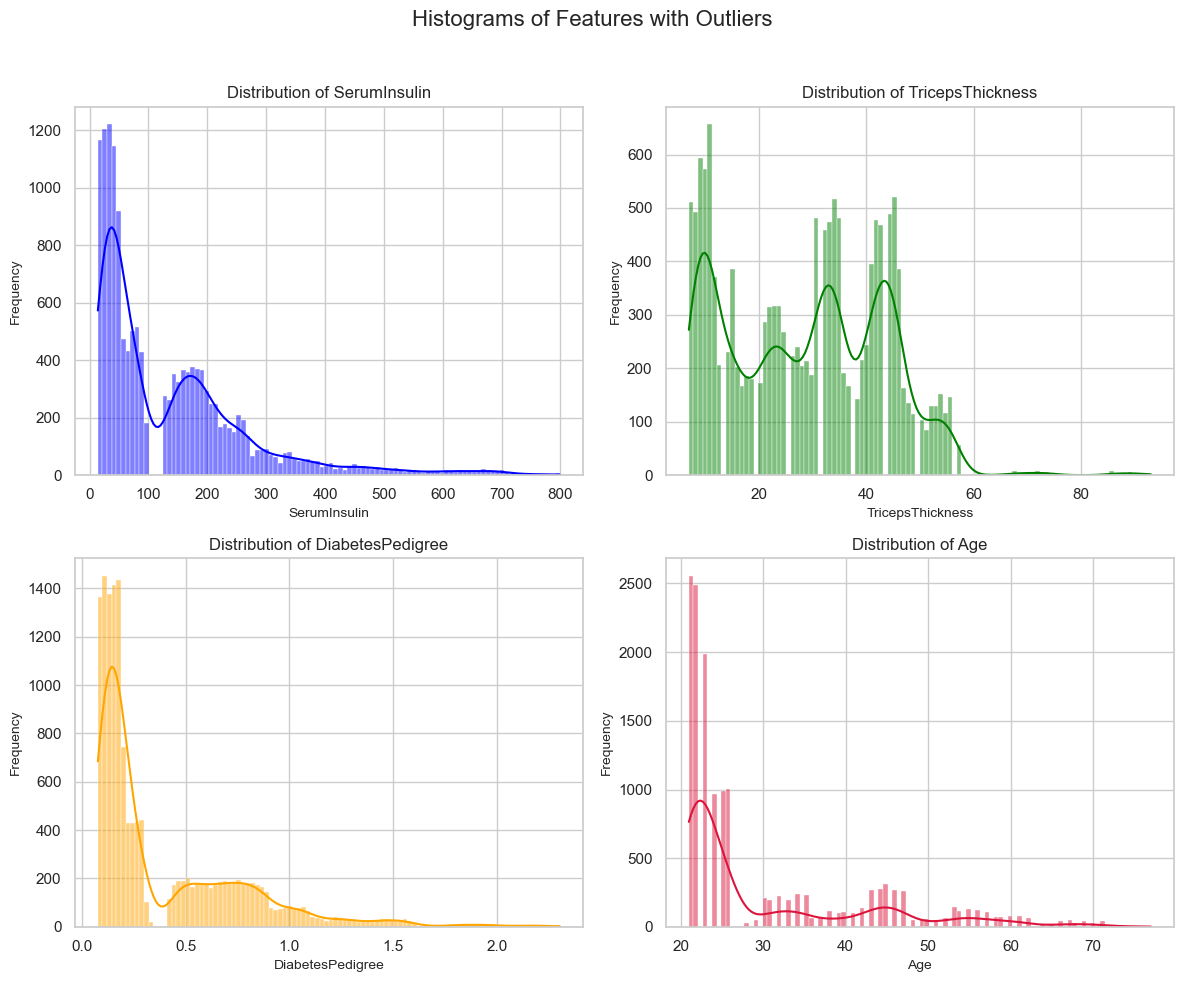

In [8]:
from util import plot_histograms_with_outliers


outliers_features = ['SerumInsulin', 'TricepsThickness', 'DiabetesPedigree', 'Age']
colors = ['blue', 'green', 'orange', 'crimson']
plot_histograms_with_outliers(df, outliers_features, colors)

When we focus on the type of distribution of the variables with outliers, we can see that most of them have a more or less skewed shape.  

Based on that, we may be tempted to keep the outliers and simply apply a $\log$ transformation to reduce their impact.  

However, before proceeding further, let's check the potential impact this may have on the balance of the current classes.

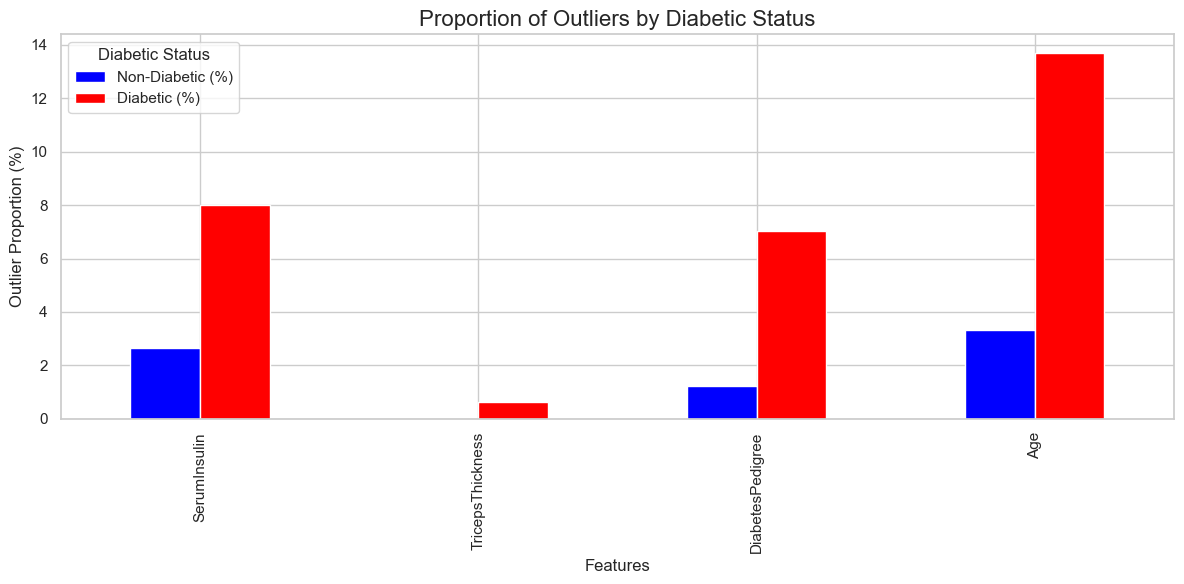

In [9]:
from util import plot_outlier_proportions

outliers_features = ['SerumInsulin', 'TricepsThickness', 'DiabetesPedigree', 'Age']
plot_outlier_proportions(df, outliers_features)

We can clearly see that, most of the time, the outliers belong to the class of individuals with diabetes, which is class **1**.  

Remember that this is the underrepresented class in the dataset. Therefore, by removing or reducing the impact of the outliers, we risk losing a lot of valuable and especially 'rare' information related to our imbalanced target variable.  

For now, we may decide to keep them and later evaluate whether our models perform better without them.  

Now, let's determine whether it would be beneficial to apply functional transformations to some variables or to remove them from the dataset.

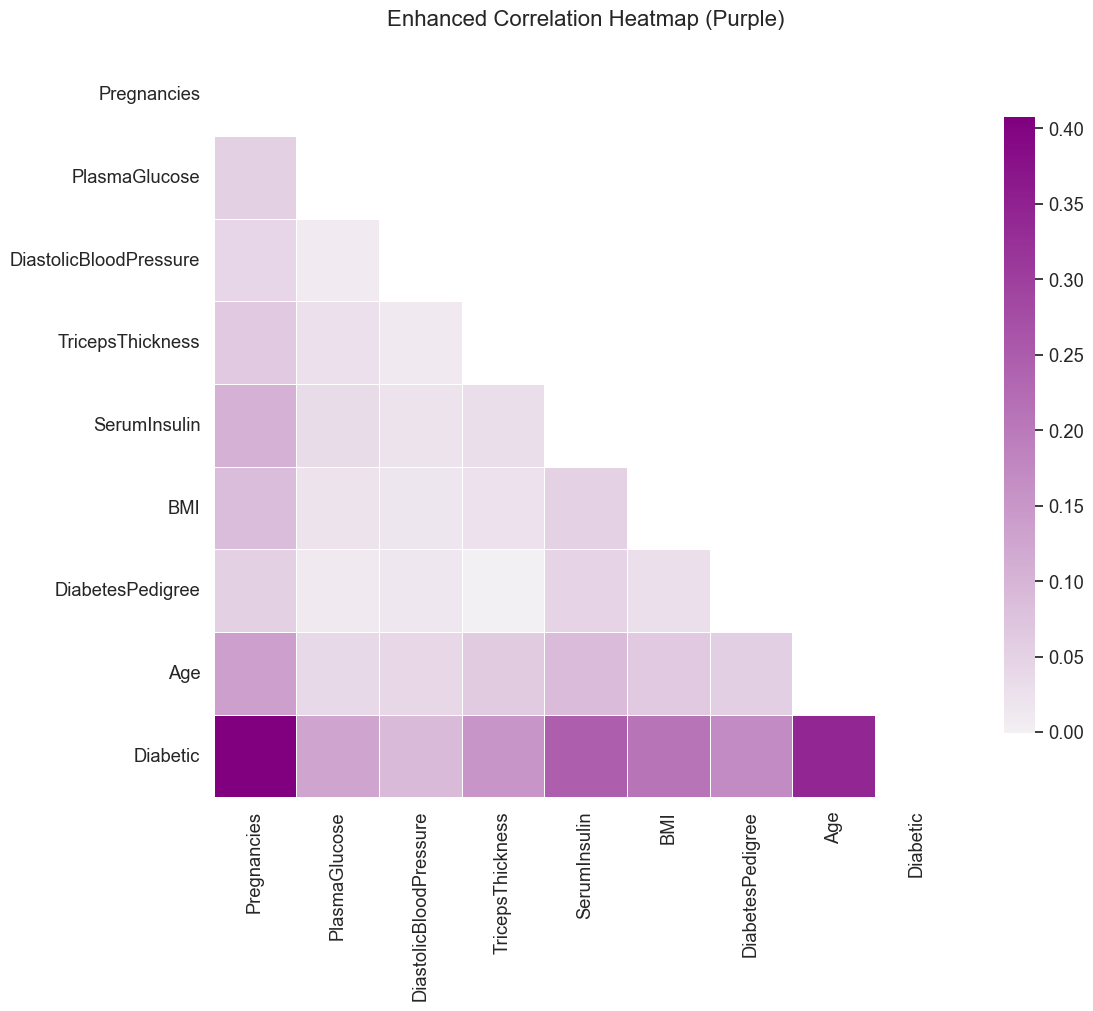

In [10]:
from util import plot_correlation_heatmap

plot_correlation_heatmap(df)

Based on the correlation plot, all our variables have a correlation below 0.5, which means we can keep all the variables in our dataset due to the lack of significant correlation between them.  

Now, let's check if pairs of variables can clearly define clusters of individuals with diabetes or not.  

Let's examine this using a pairplot.

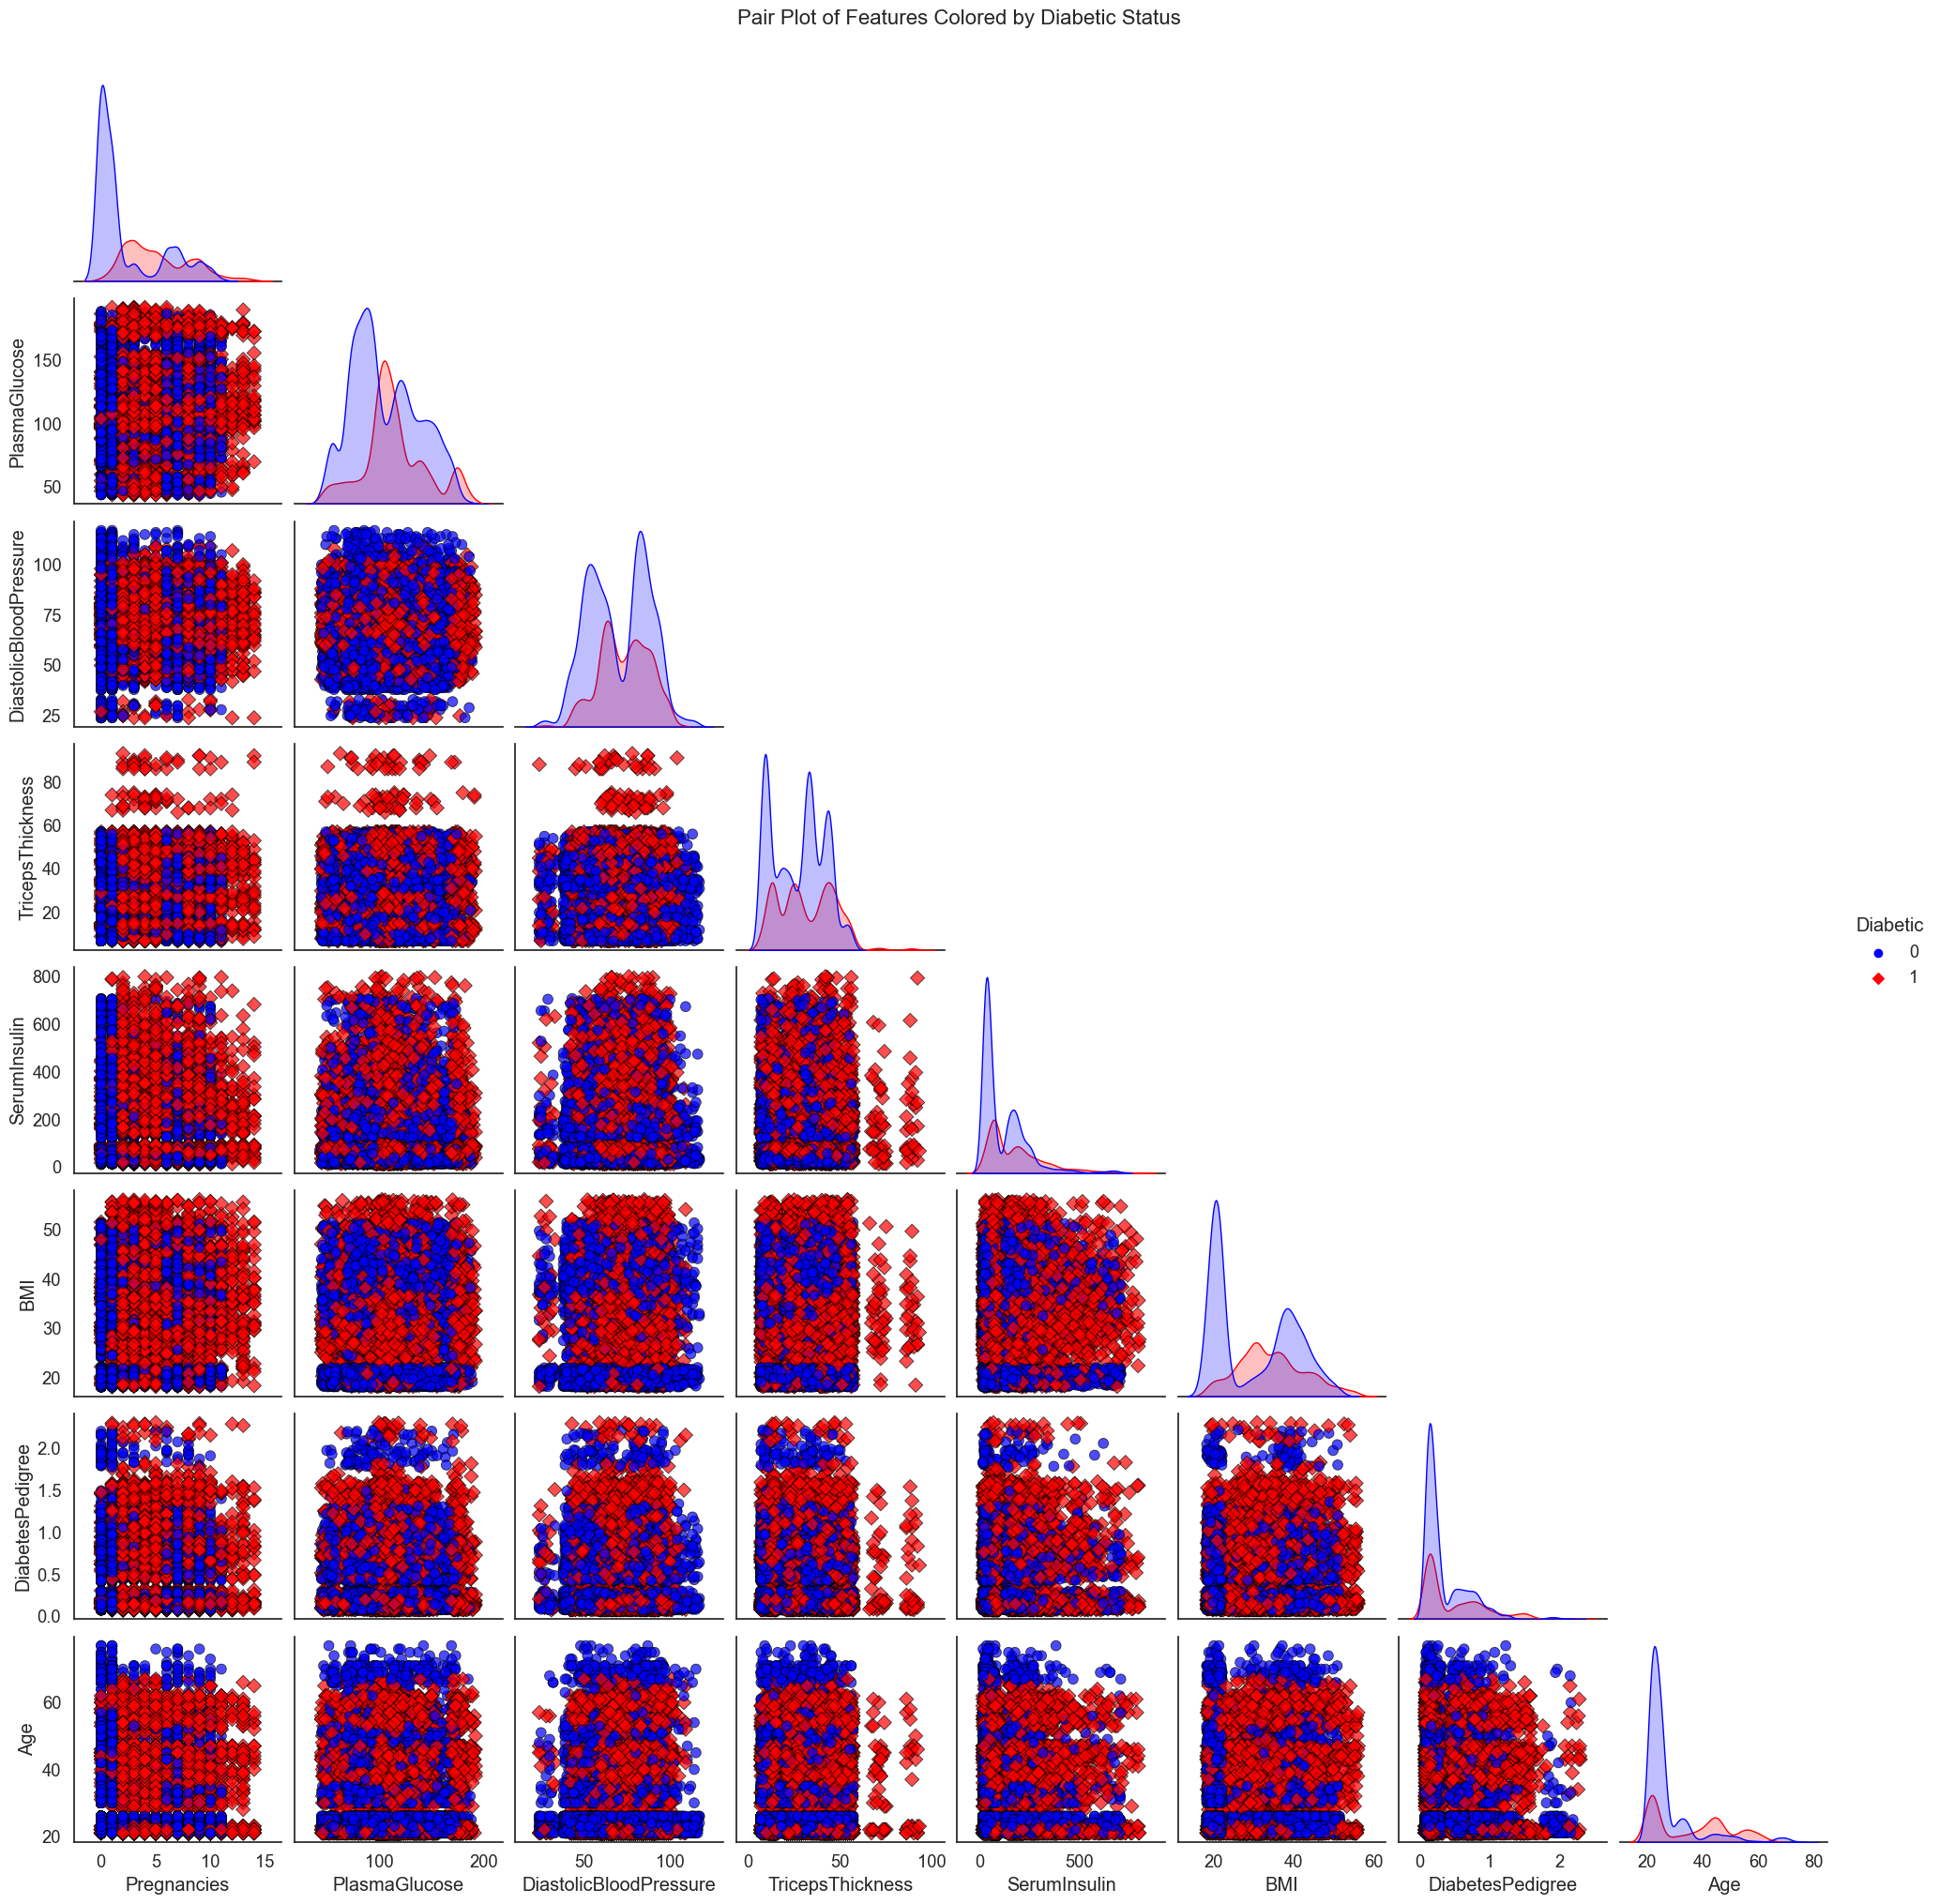

In [11]:
from util import plot_pairplot

plot_pairplot(df)

As we can see on the graph, the answer is no.

Let's check if, individually, some variables are irrelevant for predicting whether or not a person has **Diabetes**.

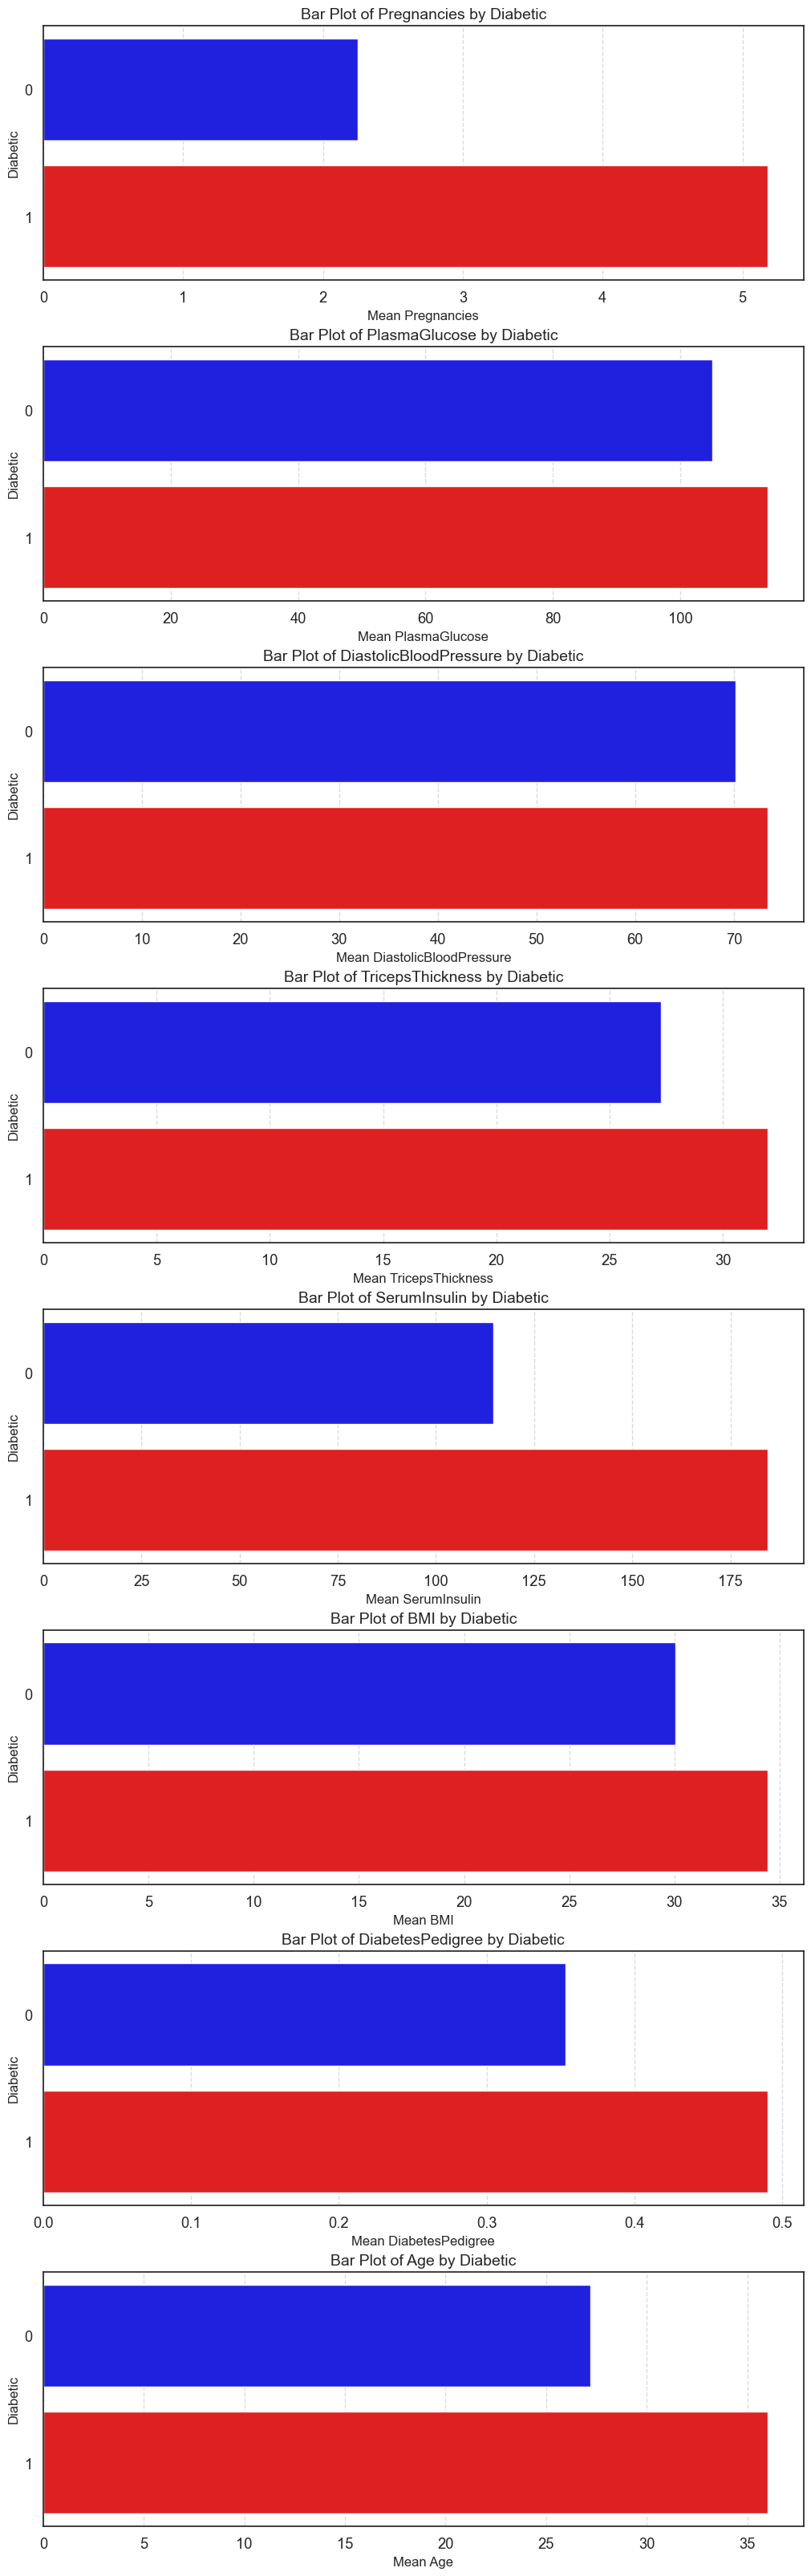

In [12]:
from util import plot_horizontal_bar_in_rows

plot_horizontal_bar_in_rows(df, binary_column="Diabetic")

Based on the graphics, the only variables that have high relevance are **Pregnancies** and **is_outlier**. The others, I would say, have medium to low relevance.  

Let's perform some statistical tests to check if there are significant differences between groups, even if the differences are small. In our case, we are working with a limited amount of data, so we can afford to keep as many variables as possible, even if their impact is low. Statistical significance may be sufficient.  

We will use the **Mann-Whitney test** because its conditions are very easy to fulfill, and by default, we meet them. This makes it a straightforward 'plug and play' option (unlike the t-test).

In [13]:
from util import  mann_whitney_test

mann_whitney_test(df, binary_var="Diabetic")

Results of Mann-Whitney U Test for 'Diabetic':
                 Variable  U statistic        p-value  is_significant
0             Pregnancies   10473690.0   0.000000e+00            True
1           PlasmaGlucose   20570666.5   3.066940e-70            True
2  DiastolicBloodPressure   22193930.0   3.035833e-29            True
3        TricepsThickness   20390006.5   5.597841e-76            True
4            SerumInsulin   15619295.0  3.980423e-308            True
5                     BMI   18808251.0  2.076209e-135            True
6        DiabetesPedigree   21615572.0   9.424051e-42            True
7                     Age   18747808.0  8.794664e-140            True


Based on the test results, we will keep all the features in our dataset.  

Now, let's move on to machine learning.


# III. Machine Learning: Model Selection, Comparison, and Evaluation  

## III.1 Model Selection Rationale  

### **Context and Goals**  
Our task is a **classification problem** with **15,000 observations**, and our primary objective is to build the **best prediction model** rather than interpret variables. We do not require feature importance analysis, so we can explore a wide range of models.  

### **EDA Insights to Guide Model Selection**  
From our exploratory data analysis (EDA):  
1. **No clear linear separability** between classes (observed via pairplots).  
2. **Significant distribution differences** in features between target groups.  

These findings suggest that **non-linear models** (e.g., trees, ensemble methods) could outperform linear models like GLM. However, we will start with simpler models to establish a baseline.  

### **Candidate Models**  
We will test the following models, progressing from simple to complex:  
- **GLM (Generalized Linear Model)**: Linear baseline for comparison.  
- **Decision Tree**: Simple non-linear model to test decision boundaries.  
- **Random Forest**: Ensemble method to improve robustness via bagging.  
- **XGBoost**: Advanced gradient-boosted trees for potentially higher performance.  

This approach allows us to determine if simpler models suffice or if we need advanced models like **XGBoost**.  

## III.2 Cross-Validation Strategy  

### **Why Cross-Validation?**  
To evaluate model performance robustly, we use **k-fold cross-validation**. This method:  
- Provides an **estimate of mean accuracy** while accounting for variance.  
- Ensures **robust evaluation** by averaging results over multiple splits.  
- Prevents overfitting to a specific train-test split.  

### **Choice of 10-Fold Cross-Validation**  
We select **10-fold cross-validation** as our default strategy for the following reasons:  

#### 1. **Balanced Computational Efficiency**  
- **15,000 observations** require a method that avoids excessive computation:  
  - **LOO (Leave-One-Out)** would require **15,000 iterations**, which is impractical for complex models like XGBoost.  
  - **10-fold** requires only **10 iterations**, reducing computational load while maintaining accuracy.  

#### 2. **Optimal Test Set Size**  
- Each fold’s test set contains **1,500 observations** (15,000 / 10), which is large enough to:  
  - Capture meaningful patterns in the data.  
  - Reduce variance in performance estimates compared to smaller folds (e.g., 100-fold’s 150 observations per test set).  

#### 3. **Stratification for Class Imbalance**  
- We use **stratified k-fold** to ensure each fold maintains the **original class distribution**.  
  - Example: If the target class 0 represents 66.7% of the data, each fold’s test set will also have ~66.7% class 0.  
  - This avoids bias in evaluation caused by uneven class representation.  

#### 4. **Deployment Readiness**  
- The final model will be trained on the **entire dataset** before deployment.  
- Using 10-fold ensures that models are evaluated on training sets of **90% of the data**, closely resembling the final training conditions.  

#### 5. **Standard Practice**  
- 10-fold is a widely accepted default in machine learning for its **balance between bias and variance**.  
- It strikes a practical middle ground between extreme methods like LOO (high variance, high computation) and 5-fold (less data per fold).  


## III.3 Model Evaluation Criteria  

### **Baseline Performance**  
Our baseline is the **naive predictor**, which always predicts the majority class (class 0, 66.7% prevalence). This yields an error rate of **33.33%**.  

### **Key Metrics**  
Voici votre texte corrigé et amélioré, intégrant les recommandations méthodologiques et une structure plus claire :

We will prioritize metrics that align with the real-world performance and business requirements of our problem:  

- **Accuracy (Primary Metric):** While accuracy will be reported, we acknowledge its limitations in imbalanced scenarios. It may overstate performance if the model defaults to predicting the majority class. We will use it cautiously and cross-validate with other metrics.   

- **Threshold Selection:** Using the ROC curve, we will determine the optimal probability threshold for deployment. This threshold balances sensitivity (true positive rate) and specificity (true negative rate), depending on the business context. We will determine if that can have a positive impact on the absolute quality of the model.  

By combining these metrics, we ensure a comprehensive evaluation of model performance while addressing the challenges posed by class imbalance and real-world deployment requirements. 

### **Model Selection Criteria**  
- Models must **outperform the naive baseline** (i.e., achieve >66.7% accuracy).  
- We will prefer models with **high AUC-ROC** and **low variance** across folds.  
- For comparable performance, simpler models (e.g., GLM) may be preferred for interpretability.  


## III.4 Implementation Plan  

1. **Preprocessing**:  
   - Use all features (as per EDA).  
   - Normalize/standardize if necessary (e.g., for GLM).  

2. **Training Pipeline**:  
   - Split data into **stratified 10 folds**.  
   - Train each model on **9 folds** (90% of data), test on the remaining fold.  
   - Repeat for all folds and compute mean metrics.  

3. **Hyperparameter Tuning**:  
   - For complex models (e.g., XGBoost), use nested cross-validation.  

4. **Final Model**:  
   - Train the best-performing model on the **entire dataset**.  
   - Deploy with confidence in its generalization to unseen data.  


### **Conclusion**  
The **10-fold cross-validation strategy** is an optimal solution for our problem due to its computational efficiency, robustness, and alignment with deployment needs. It ensures that models are rigorously evaluated while maintaining practicality for a dataset of this size.  

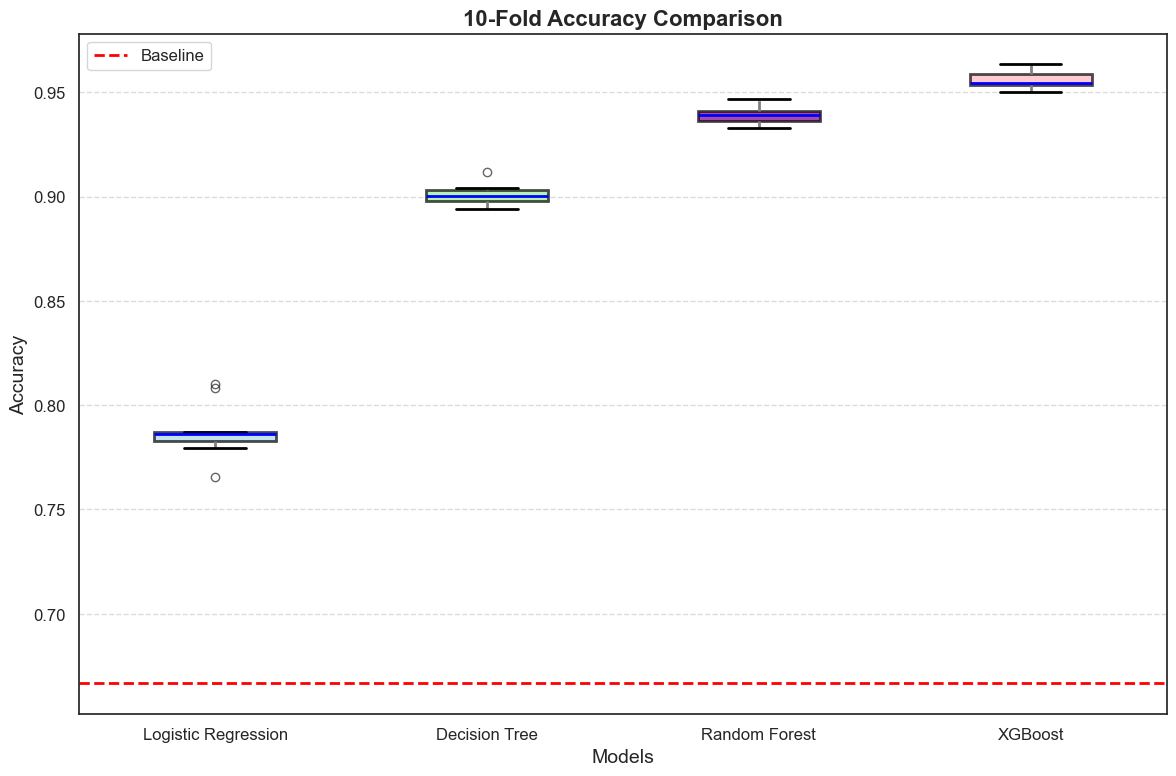

In [14]:
from util import evaluate_and_plot_models

evaluate_and_plot_models(df, target="Diabetic", n_splits=10)

As expected from our EDA and the models tested, **XGBoost** (a well-known competitive model) outperforms all others. However, it’s worth noting that all the models we tested perform better than the baseline, which is great.  

Let’s move forward quickly with feature engineering specifically tailored for **XGBoost**.

We propose creating new features from the following variables that were shown to contain outliers:
- `SerumInsulin`
- `TricepsThickness`  
- `DiabetesPedigree`
- `Age`

**Approach**:  
For each of these variables, we'll create modified versions where:
- Zero values are replaced with the actual value when it's not an outlier
- Outliers are handled separately

This transformation might help the model better handle edge cases and improve overall performance by:
1. Preserving valid non-outlier information
2. Explicitly flagging outlier cases
3. Reducing the impact of extreme values

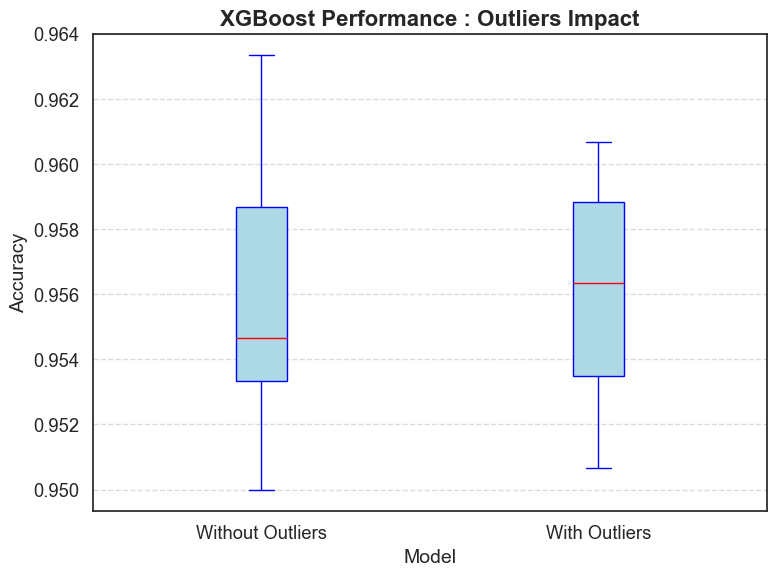

In [15]:
from util import xgboost_outliers_impacts

xgboost_outliers_impacts(df, target="Diabetic", n_splits=10)

As we can see in this graph, our approch improve the model slightly the mean and the variance of the accuracy. So we can should keep those variable and move on this that.

### Model Optimization Strategy : XGBoost Hyperparameter

## Motivation

Our systematic hyperparameter tuning serves three key purposes:

1. **Performance Maximization**  
   XGBoost's effectiveness heavily depends on proper parameter configuration. The default values rarely yield optimal results for specific datasets.

2. **Overfitting Prevention**  
   Through careful regularization tuning (`reg_alpha`, `reg_lambda`, `gamma`), we maintain the model's generalization capability while capturing meaningful patterns.

3. **Computational Efficiency**  
   Balanced parameter selection (`n_estimators` with `learning_rate`) ensures we achieve maximum accuracy with minimal unnecessary computations.

## Implementation Rationale

The chosen parameters address different aspects of model behavior:

- **Tree Structure** (`max_depth`, `min_child_weight`): Controls model complexity
- **Learning Process** (`learning_rate`, `n_estimators`): Manages gradient descent convergence
- **Robustness** (`subsample`, `colsample_bytree`): Introduces beneficial randomness
- **Imbalance Handling** (`scale_pos_weight`): Adjusts for unequal class distributions which specially relevant to our use case

## Expected Outcomes

Proper optimization should yield:
- improvement in test accuracy
- More stable predictions across different data splits

## Method

In order to to that, we will use the **Optuna** library which a cutting-edge hyperparameter optimization through:

- **Bayesian optimization** with Tree-structured Parzen Estimator (TPE)  
- **Automatic pruning** of unpromising trials  
- **Distributed optimization** across multiple nodes  
- **Visual analytics** for parameter importance  

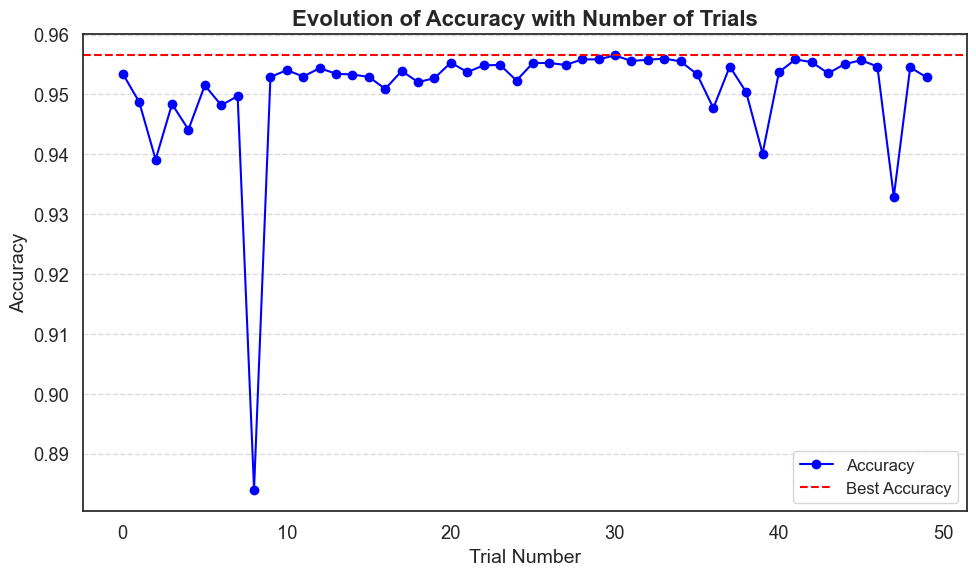

Best parameters: {'n_estimators': 181, 'learning_rate': 0.17911758506048855, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8070860120989212, 'colsample_bytree': 0.6776143704910574, 'scale_pos_weight': 3.774454880854858}
Best cross-validated accuracy: 0.9565333333333333


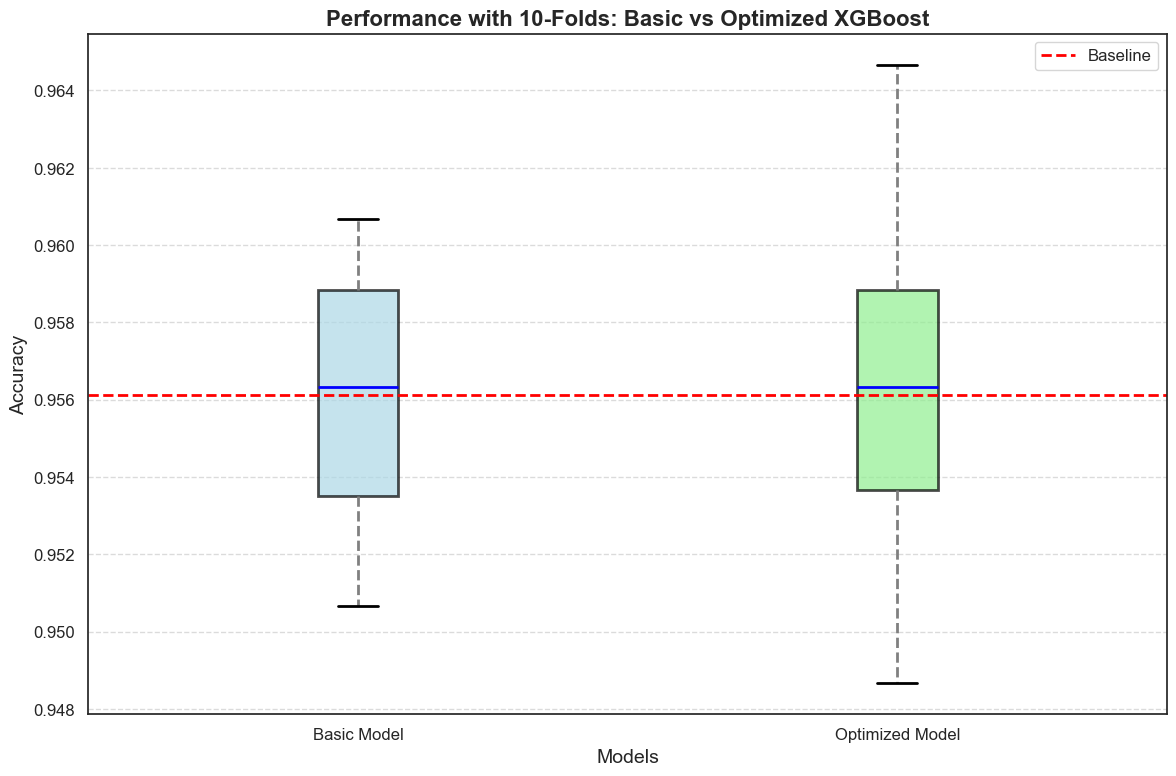

In [16]:
from util import optimize_and_compare_xgboost
X = df[df.columns.drop(["Diabetic"])]
y = df["Diabetic"]

optimized_model, study = optimize_and_compare_xgboost(X, y, n_trials=50, n_splits=10)

We gain nothing from this, so there is no need to add these configurations to the model.

However, we still want to compute the optimal threshold using the ROC curve and check whether changing the decision threshold from **0.5** to an estimated optimal value improves the overall quality.

## ROC Curve

Mean Optimal Threshold: 0.34
Mean ROC AUC: 0.99


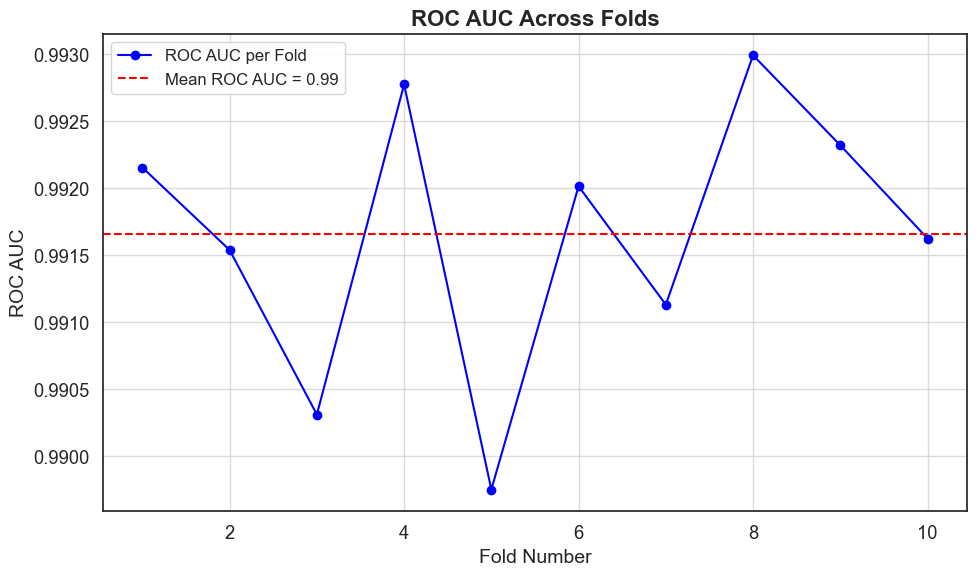

In [17]:
from util import calculate_optimal_threshold_with_kfolds

mean_optimal_threshold = calculate_optimal_threshold_with_kfolds(df)

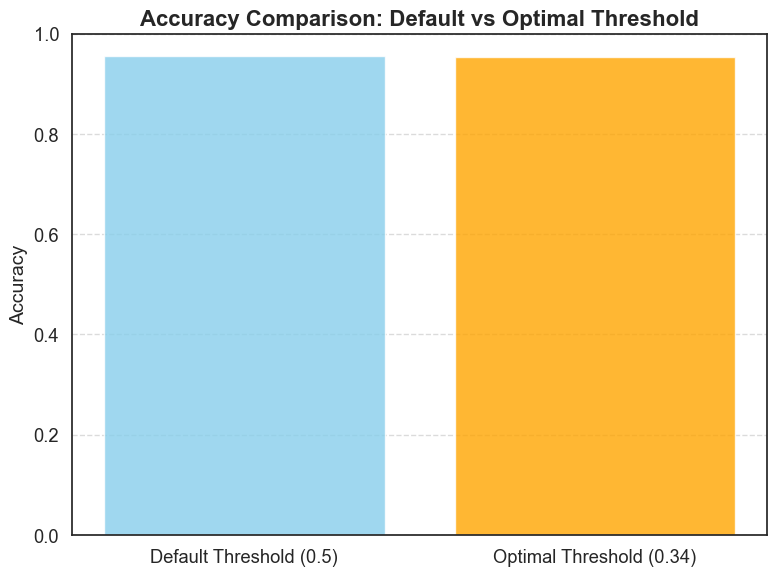

Accuracy with Default Threshold (0.5): 0.96
Accuracy with Optimal Threshold (0.34): 0.95


In [18]:
from util import  compare_xgboost_accuracy

compare_xgboost_accuracy(df, optimal_threshold=0.34)

The can simply use the XGBoost as it is.